In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
import numpy as np

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flattening the tensor
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [ ]:
from torchvision import models

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ModifiedResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 256)
    def forward(self, x):
        x = self.resnet(x)
        return x


In [ ]:
#combing resnet and cnn
class CombinedModel(nn.Module):
    def __init__(self, num_classes=6):
        super(CombinedModel, self).__init__()
        self.custom_cnn = CustomCNN(num_classes)
        self.modified_resnet = ModifiedResNet(num_classes)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        custom_out = self.custom_cnn(x)
        resnet_out = self.modified_resnet(x)
        combined_out = torch.cat((custom_out, resnet_out), dim=1)
        out = self.fc(combined_out)
        return out


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#functions below are the ones used in lab2/lab3 of APS360
def evaluate(net, loader, criterion):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            total_err += (predicted != labels).sum().item()
    accuracy = total_correct / total_samples
    err = float(total_err) / total_samples
    loss = float(total_loss) / (i + 1)
    return accuracy, err, loss


def loader(train_images, val_images, test_images, batch_size=64):
    train_loader = torch.utils.data.DataLoader(train_images, batch_size=batch_size, num_workers=2, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_images, batch_size=batch_size, num_workers=2, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_images, batch_size=batch_size, num_workers=2, shuffle=True)
    return train_loader, val_loader, test_loader

def train(model, train_images, val_images, test_images, batch_size=64, lr=0.001, num_epochs=30):
    torch.manual_seed(10)

    # Move the model to GPU
    model.to(device)

    train_loader, val_loader, test_loader = loader(train_images, val_images, test_images, batch_size)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_train_correct = 0
        total_train_samples = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)
            total_train_loss += loss.item()
            total_train_err += (predicted != labels).sum().item()

        train_acc[epoch] = total_train_correct / total_train_samples
        train_err[epoch] = float(total_train_err) / total_train_samples
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_acc[epoch], val_err[epoch], val_loss[epoch] = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch + 1}: Train Acc: {train_acc[epoch]:.4f}, Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | Validation Acc: {val_acc[epoch]:.4f}, Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        #saving model after
        if (True):
            model_path = f"model_{model.__class__.__name__}_bs{batch_size}_lr{lr}_epoch{epoch + 1}.pth"
            torch.save(model.state_dict(), model_path)

    print('Finished Training')
    elapsed_time = time.time() - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")

    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model.__class__.__name__}_train_acc.csv", train_acc)
    np.savetxt(f"{model.__class__.__name__}_train_err.csv", train_err)
    np.savetxt(f"{model.__class__.__name__}_train_loss.csv", train_loss)
    np.savetxt(f"{model.__class__.__name__}_val_acc.csv", val_acc)
    np.savetxt(f"{model.__class__.__name__}_val_err.csv", val_err)
    np.savetxt(f"{model.__class__.__name__}_val_loss.csv", val_loss)


In [ ]:
###########      Plotting data from lab2        #############

def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()


In [ ]:
from torchvision import transforms, datasets

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_images = datasets.ImageFolder('/content/drive/MyDrive/aps360/Processed Data/training_database/rice', transform=transform)
val_images = datasets.ImageFolder('/content/drive/MyDrive/aps360/Processed Data/validation_database/rice', transform=transform)
test_images = datasets.ImageFolder('/content/drive/MyDrive/aps360/Processed Data/testing_database/rice', transform=transform)


In [25]:
model = CombinedModel(num_classes = 6)
train(model, train_images,val_images, test_images,batch_size=256, lr=0.0001, num_epochs=150) #92.14 at 58th epoch is the best validation accuracy

Epoch 1: Train Acc: 0.3887, Train err: 0.6113, Train loss: 2.6410 | Validation Acc: 0.5381, Validation err: 0.4619, Validation loss: 4.1194
Epoch 2: Train Acc: 0.7322, Train err: 0.2678, Train loss: 0.8352 | Validation Acc: 0.4405, Validation err: 0.5595, Validation loss: 9.4376
Epoch 3: Train Acc: 0.8142, Train err: 0.1858, Train loss: 0.6543 | Validation Acc: 0.6167, Validation err: 0.3833, Validation loss: 6.6351
Epoch 4: Train Acc: 0.8866, Train err: 0.1134, Train loss: 0.3563 | Validation Acc: 0.7690, Validation err: 0.2310, Validation loss: 2.3949
Epoch 5: Train Acc: 0.8866, Train err: 0.1134, Train loss: 0.3454 | Validation Acc: 0.6524, Validation err: 0.3476, Validation loss: 1.9562
Epoch 6: Train Acc: 0.9249, Train err: 0.0751, Train loss: 0.2407 | Validation Acc: 0.8595, Validation err: 0.1405, Validation loss: 0.7363
Epoch 7: Train Acc: 0.9399, Train err: 0.0601, Train loss: 0.1892 | Validation Acc: 0.8762, Validation err: 0.1238, Validation loss: 0.4910
Epoch 8: Train Acc: 

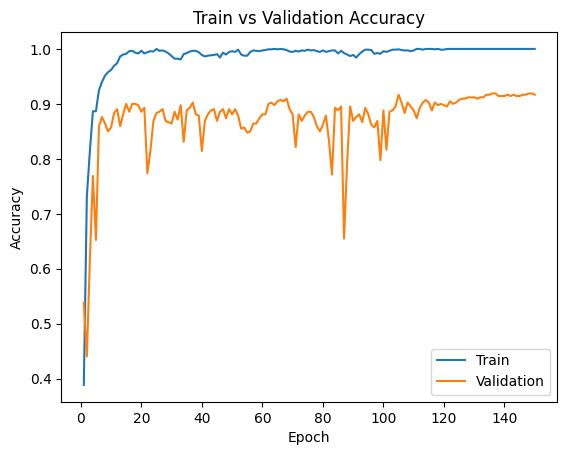

In [26]:
def plot_acc():
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("/content/CombinedModel_train_acc.csv")
    val_acc = np.loadtxt("/content/CombinedModel_val_acc.csv")
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
plot_acc()

True label: 2


Predicted label: 2


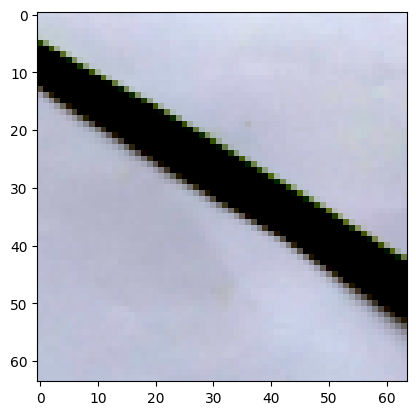

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

index = random.randint(0, len(val_images) - 1)
image, true_label = val_images[index]
print("True label:", true_label)

# Moving the image to CUDA
image = image.to(device)

resized_image = F.interpolate(image.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False)

#Put image on CUDA
resized_image = resized_image.to(device)

output = model(resized_image)
_, predicted_label = torch.max(output, 1)
print("Predicted label:", predicted_label.item())

# Moving the image back to CPU for visualization
image = image.cpu()

plt.imshow(image.permute(1, 2, 0))
plt.show()

True label: 0
Predicted label: 0


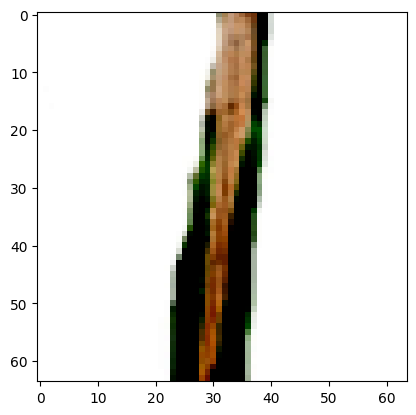

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

index = random.randint(0, len(val_images) - 1)
image, true_label = val_images[index]
print("True label:", true_label)

# Moving the image to CUDA
image = image.to(device)

resized_image = F.interpolate(image.unsqueeze(0), size=(64, 64), mode='bilinear', align_corners=False)

#Put image on CUDA
resized_image = resized_image.to(device)

output = model(resized_image)
_, predicted_label = torch.max(output, 1)
print("Predicted label:", predicted_label.item())

# Moving the image back to CPU for visualization
image = image.cpu()

plt.imshow(image.permute(1, 2, 0))
plt.show()